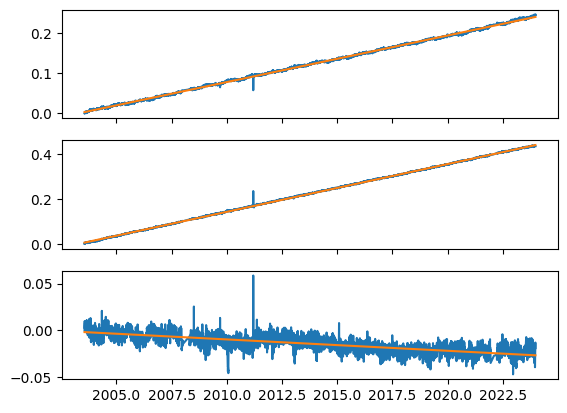

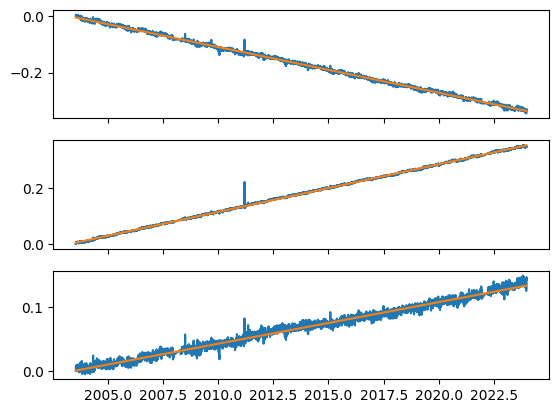

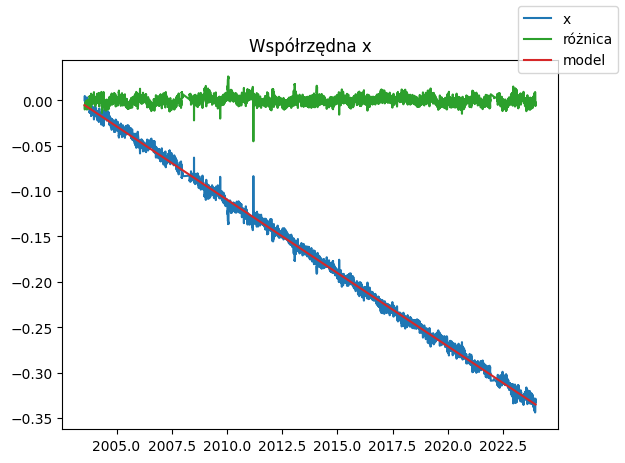

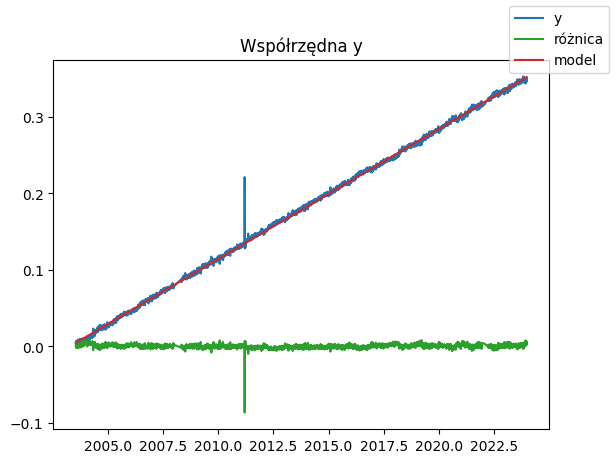

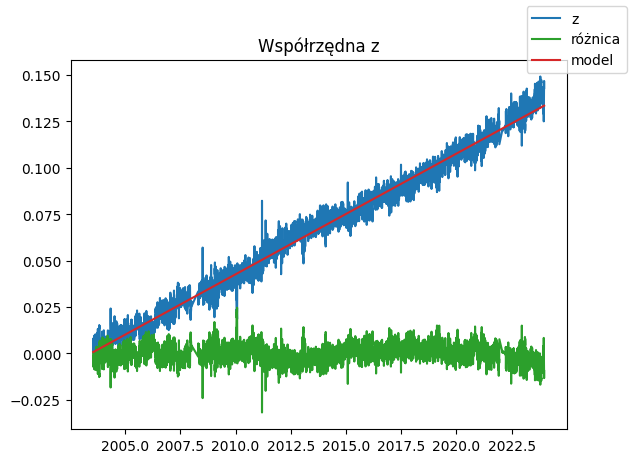

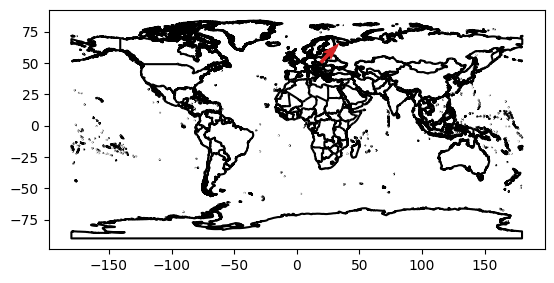

In [4]:
import numpy as np
import matplotlib.pyplot as plt

myblue = "#1f77b4"
mygreen = "#2ca02c"
myred = "#d62728"
myorange = "#ff7f0e"

a = 6378137.0
e2 = 0.00669438002290

# Promienie krzywizny
def Mp(phi):
    return a * (1 - e2) / (1 - e2 * np.sin(phi)**2)**(3/2)

def Np(phi):
    return a / np.sqrt(1 - e2 * np.sin(phi)**2)

# Funkcja przeliczająca współrzędne geograficzne na współrzędne ortogonalne
def orto(p, l, h):
    N = a / (np.sqrt(1 - e2 * np.sin(l) * np.sin(l)))
    X = (N + h) * np.cos(p) * np.cos(l)
    Y = (N + h) * np.cos(p) * np.sin(l)
    Z = (N * (1 - e2) + h) * np.sin(p)
    return([X, Y, Z])

# Funkcja obliczająca współrzędne geograficzne na podstawie współrzędnych ortogonalnych
def hirv(x,y,z):
    p = np.sqrt(x**2+y**2)
    
    phi = np.arctan(z/(p*(1-e2)))
    
    while True:
        N = Np(phi)
        h = p/np.cos(phi) - N
        phi_poprzednie = phi
        phi = np.arctan((z/p) * (1-(N*e2)/(N+h))**(-1))
        if abs(phi_poprzednie-phi)<(0.000001/60/60/360):
            break
    lam = np.arctan2(y,x)
    return phi, lam, h

dane = np.genfromtxt("KATO.txt")

t = dane[:, 2]
xyz = dane[:, 3:6]

dxyz  = xyz - xyz[0, :]

phis = []
lams = []
hs = []

'''
for i in range(len(dxyz)):
    p, l, h = hirv(xyz[i, 0], xyz[i, 1], xyz[i, 2])
    phis.append(p)
    lams.append(l)
    hs.append(h)

    Rneu = np.array([[-np.sin(p) * np.cos(l), -np.sin(l), np.cos(p) * np.cos(l)],
                    [-np.sin(p) * np.sin(l), np.cos(l), np.cos(p) * np.sin(l)],
                    [np.cos(p), 0, np.sin(p)]])
'''

p, l, h = hirv(xyz[0, 0], xyz[0, 1], xyz[0, 2])
Rneu = np.array([[-np.sin(p) * np.cos(l), -np.sin(l), np.cos(p) * np.cos(l)],
                    [-np.sin(p) * np.sin(l), np.cos(l), np.cos(p) * np.sin(l)],
                    [np.cos(p), 0, np.sin(p)]])

dneu = []
for dx in dxyz:
    dneu.append(Rneu.T@dx)
dneu = np.array(dneu)

jedynki = np.ones(len(t))
A = np.column_stack((t, jedynki))

fig, ax = plt.subplots(3, 1, sharex=True)
ax[0].plot(t, dneu[:, 0], label="x")
ax[1].plot(t, dneu[:, 1], label="y")
ax[2].plot(t, dneu[:, 2], label="z")

#linia najlepszego dopasowania
liniax = np.linalg.inv(A.T@A)@(A.T@dneu[:, 0])
model = A@liniax
ax[0].plot(t, model, label="model")
liniay = np.linalg.inv(A.T@A)@(A.T@dneu[:, 1])
model = A@liniay
ax[1].plot(t, model, label="model")
liniaz = np.linalg.inv(A.T@A)@(A.T@dneu[:, 2])
model = A@liniaz
ax[2].plot(t, model, label="model")

# macierzy wyrazów wolnych
def macierz_wyr(wspol, t, A = A):
    L = wspol
    wsp_wsp = np.linalg.inv(A.T@A)@(A.T@L)
    model = A@wsp_wsp
    v = model - L
    return A, L, model, v

x = dxyz[:, 0]
Ax, Lx, modelx, vx = macierz_wyr(x, t)
y = dxyz[:, 1]
Ay, Ly, modely, vy = macierz_wyr(y, t)
z = dxyz[:, 2]
Az, Lz, modelz, vz = macierz_wyr(z, t)

''' 
# schodek w modelu dla roku 2013
th = 2013

H = jedynki 
indeksyH = t < th
H = H[indeksyH]
A =  np.column_stack(A, H)
'''

### WYKRESY ###

# Wykresy współrzędnych x, y, z w funkcji czasu
fig, ax = plt.subplots(3, 1, sharex=True)
ax[0].plot(t, dxyz[:, 0], label="x")
ax[1].plot(t, dxyz[:, 1], label="y")
ax[2].plot(t, dxyz[:, 2], label="z")

#linia najlepszego dopasowania
ax[0].plot(t, modelx, label="model")
ax[1].plot(t, modely, label="model")
ax[2].plot(t, modelz, label="model")

# Wykresy współrzędnej x
fig, ax = plt.subplots()
ax.plot(t, dxyz[:, 0], label="x", color=myblue)
ax.plot(t, vx, label="różnica", color=mygreen)
ax.plot(t, modelx, label="model", color=myred)
fig.legend()
ax.set_title("Współrzędna x")

fig, ax = plt.subplots()
ax.plot(t, dxyz[:, 1], label="y", color=myblue)
ax.plot(t, vy, label="różnica", color=mygreen)
ax.plot(t, modely, label="model", color=myred)
fig.legend()
ax.set_title("Współrzędna y")

fig, ax = plt.subplots()
ax.plot(t, dxyz[:, 2], label="z", color=myblue)
ax.plot(t, vz, label="różnica", color=mygreen)
ax.plot(t, modelz, label="model", color=myred)
fig.legend()
ax.set_title("Współrzędna z")

# Narysowanie coastlines
import geopandas as gpd

shpfile = gpd.read_file("CNTR_BN_03M_2020_4326.shp")

fig, ax = plt.subplots()
shpfile.plot(ax = ax, color = 'black', edgecolor = 'black', zorder = 1)

#vn = (modely[-1, 0] - modely[0, 0]) / (t[-1] - t[0]) * 100
#ve = (modelx[-1, 1] - modelx[0, 1]) / (t[-1] - t[0]) * 100
#r'$ 1 \frac{m}{s}$'


# wektor prędkości
vn = (modely[-1] - modely[0]) / (t[-1] - t[0]) * 100
ve = (modelx[0] - modelx[-1]) / (t[-1] - t[0]) * 100

Q = ax.quiver(np.rad2deg(l), np.rad2deg(p), ve, vn, color = myred, zorder = 2)
ax.quiverkey(Q, 0.9, 0.9, 1, labelpos='E', coordinates='figure', label=r'$ 1 \frac{cm}{year}$')
